In [8]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf 
import random 
from collections import deque

In [2]:
start_date = "2010-01-01"
end_date = "2018-12-31"

# download LNT stock price data
stock_data = yf.download("LT.NS", start=start_date, end=end_date)
stock_data.to_csv('lnt_stock_data.csv', index=False)

# download RELIANCE stock price data
stock_data = yf.download("RELIANCE.NS", start=start_date, end=end_date)
stock_data.to_csv('reliance_stock_data.csv', index=False)

print("Data collection and saving complete.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Data collection and saving complete.


In [2]:
# Reading the data
stock_data = pd.read_csv("lnt_stock_data.csv")[["Close"]]
stock_data.describe()

,Close
count,2218.000000
mean,901.464703
std,248.912473
min,434.533325
25%,693.183350
50%,869.311127
75%,1113.549988
max,1455.599976


In [11]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [22]:
class DQN_Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []


        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999


        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(self.cost)
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
        
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
        
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [23]:
df = pd.read_csv("lnt_stock_data.csv")
close = df.Close.values.tolist()
train_data = close[:int(len(close) * 0.8)]
test_data = close[int(len(close) * 0.8):]

initial_money = 1000000
window_size = 30
skip = 1
batch_size = 32
agent = DQN_Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)


/home/sachi/.local/lib/python3.10/site-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/tmp/ipykernel_7181/2365772992.py:24: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
/tmp/ipykernel_7181/2365772992.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


epoch: 10, total rewards: 70938.088745.3, cost: 0.444285, total money: 804478.471863
epoch: 20, total rewards: 73048.311676.3, cost: 0.190513, total money: 781775.311493
epoch: 30, total rewards: 75495.894867.3, cost: 0.179954, total money: 752796.811005
epoch: 40, total rewards: 71924.189850.3, cost: 0.075247, total money: 754723.856110
epoch: 50, total rewards: 79659.322906.3, cost: 0.059191, total money: 753739.105621
epoch: 60, total rewards: 78014.884003.3, cost: 0.045289, total money: 741585.483368
epoch: 70, total rewards: 75702.822601.3, cost: 0.041416, total money: 753168.255341
epoch: 80, total rewards: 74116.200409.3, cost: 0.033123, total money: 731862.416412
epoch: 90, total rewards: 77457.450592.3, cost: 0.027178, total money: 743755.366547
epoch: 100, total rewards: 69071.023041.3, cost: 0.030443, total money: 726434.455719
epoch: 110, total rewards: 75696.456116.3, cost: 0.024662, total money: 760788.205688
epoch: 120, total rewards: 69737.672852.3, cost: 0.019994, tota

In [24]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 744.733337, total balance 999255.266663
day 3, sell 1 unit at price 741.155579, investment -0.480408 %, total balance 999996.422241,
day 7: buy 1 unit at price 743.644470, total balance 999252.777771
day 8, sell 1 unit at price 741.511108, investment -0.286879 %, total balance 999994.288879,
day 9: buy 1 unit at price 733.866638, total balance 999260.422241
day 13: buy 1 unit at price 677.377747, total balance 998583.044495
day 16: buy 1 unit at price 648.022217, total balance 997935.022278
day 17: buy 1 unit at price 636.222229, total balance 997298.800049
day 18: buy 1 unit at price 632.822205, total balance 996665.977844
day 19, sell 1 unit at price 629.888916, investment -14.168476 %, total balance 997295.866760,
day 20, sell 1 unit at price 620.622192, investment -8.378715 %, total balance 997916.488953,
day 21, sell 1 unit at price 644.511108, investment -0.541819 %, total balance 998561.000061,
day 22, sell 1 unit at price 642.133362, investment 0.9290

NameError: name 'name' is not defined

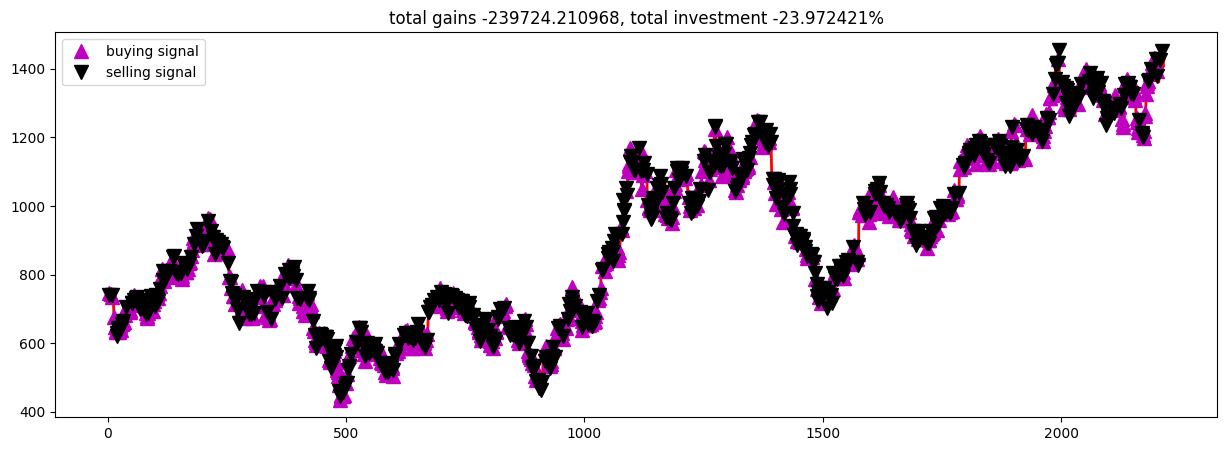

In [30]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

In [26]:
total_gains

-239724.21096801758